In [1]:
import cv2
import copy
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm

from aijack.attack import GradientInversion_Attack
from aijack.utils import NumpyDataset

In [2]:
torch.cuda.is_available()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [3]:
class LeNet(nn.Module):
    def __init__(self, channel=3, hideen=768, num_classes=10):
        super(LeNet, self).__init__()
        act = nn.Sigmoid
        self.body = nn.Sequential(
            nn.Conv2d(channel, 12, kernel_size=5, padding=5 // 2, stride=2),
            nn.BatchNorm2d(12),
            act(),
            nn.Conv2d(12, 12, kernel_size=5, padding=5 // 2, stride=2),
            nn.BatchNorm2d(12),
            act(),
            nn.Conv2d(12, 12, kernel_size=5, padding=5 // 2, stride=1),
            nn.BatchNorm2d(12),
            act(),
        )
        self.fc = nn.Sequential(
            nn.Linear(hideen, num_classes)
        )

    def forward(self, x):
        out = self.body(x)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

In [4]:
def prepare_dataloader(path="MNIST/.", batch_size = 64, shuffle=True):
    at_t_dataset_train = torchvision.datasets.MNIST(
        root=path, train=True, download=True
    )

    transform = transforms.Compose(
        [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]
    )

    dataset = NumpyDataset(
        at_t_dataset_train.train_data.numpy(),
        at_t_dataset_train.train_labels.numpy(),
        transform=transform,
    )

    dataloader = torch.utils.data.DataLoader(
        dataset, batch_size=batch_size, shuffle=shuffle, num_workers=0
    )
    return dataloader

In [5]:
torch.manual_seed(1)

shape_img = (28, 28)
num_classes = 10
channel = 1
hidden = 588

device = torch.device("cuda:0") if torch.cuda.is_available() else "cpu"
dataloader = prepare_dataloader()
for data in dataloader:
    x, y = data[0], data[1]
    break

c:\Users\14398832\OneDrive - UTS\Desktop\GANs\.venv\lib\site-packages\torchvision\datasets\mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
c:\Users\14398832\OneDrive - UTS\Desktop\GANs\.venv\lib\site-packages\torchvision\datasets\mnist.py:65: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


## DLG Attack
https://dlg.mit.edu/assets/NeurIPS19_deep_leakage_from_gradients.pdf

- distance metric = L2 norm
- optimize both of images and labels

In [ ]:
plt.figure(figsize=(2, 4))
plt.imshow(x[:1].detach().numpy()[0][0], cmap="gray")
plt.axis("off")
plt.title("target")
plt.show()

criterion = nn.CrossEntropyLoss()
net = LeNet(channel=channel, hideen=hidden, num_classes=num_classes)
pred = net(x[:1])
loss = criterion(pred, y[:1])
received_gradients = torch.autograd.grad(loss, net.parameters())
received_gradients = [cg.detach() for cg in received_gradients]

dlg_attacker = GradientInversion_Attack(net, (1, 28, 28), lr=1.0, log_interval=0,
                                    num_iteration=100,
                                    distancename="l2")

num_seeds=5
fig = plt.figure()
for s in tqdm(range(num_seeds)):
    dlg_attacker.reset_seed(s)
    result = dlg_attacker.attack(received_gradients)
    ax1 = fig.add_subplot(2, num_seeds, s+1)
    ax1.imshow(result[0].detach().numpy()[0][0], cmap="gray")
    ax1.set_title(torch.argmax(result[1]).item())
    ax1.axis("off")
    ax2 = fig.add_subplot(2, num_seeds, num_seeds+s+1)
    ax2.imshow(cv2.medianBlur(result[0].detach().numpy()[0][0], 5), cmap="gray")
    ax2.axis("off")
plt.suptitle("Result of DLG")
plt.tight_layout()
plt.show()

## GS Attack
https://arxiv.org/abs/2003.14053
- distance metric = cosine similarity
- optimize both of images and labels
- total-variance regularization

In [ ]:
plt.figure(figsize=(2, 4))
plt.imshow(x[:1].detach().numpy()[0][0], cmap="gray")
plt.axis("off")
plt.title("target")
plt.show()

criterion = nn.CrossEntropyLoss()
net = LeNet(channel=channel, hideen=hidden, num_classes=num_classes)
pred = net(x[:1])
loss = criterion(pred, y[:1])
received_gradients = torch.autograd.grad(loss, net.parameters())
received_gradients = [cg.detach() for cg in received_gradients]

gs_attacker = GradientInversion_Attack(net, (1, 28, 28), lr=1.0, log_interval=0,
                                    num_iteration=100,
                                    tv_reg_coef=0.01,
                                    distancename="cossim")

num_seeds=5
fig = plt.figure()
for s in tqdm(range(num_seeds)):
    gs_attacker.reset_seed(s)
    result = gs_attacker.attack(received_gradients)
    ax1 = fig.add_subplot(2, num_seeds, s+1)
    ax1.axis("off")
    ax1.imshow(result[0].detach().numpy()[0][0], cmap="gray")
    ax1.set_title(torch.argmax(result[1]).item())
    ax2 = fig.add_subplot(2, num_seeds, num_seeds+s+1)
    ax2.imshow(cv2.medianBlur(result[0].detach().numpy()[0][0], 5), cmap="gray")
    ax2.axis("off")
plt.suptitle("Result of GS")
plt.tight_layout()
plt.show()

## IDLG Attack
https://arxiv.org/abs/2001.02610
- distance metric = L2 norm
- optimize only an image & estimate a label from the gradients

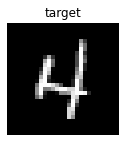

  0%|          | 0/5 [00:00<?, ?it/s]

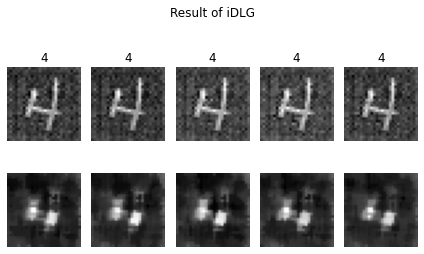

In [7]:
plt.figure(figsize=(2, 4))
plt.imshow(x[:1].detach().numpy()[0][0], cmap="gray")
plt.axis("off")
plt.title("target")
plt.show()

criterion = nn.CrossEntropyLoss()
net = LeNet(channel=channel, hideen=hidden, num_classes=num_classes)
pred = net(x[:1])
loss = criterion(pred, y[:1])
received_gradients = torch.autograd.grad(loss, net.parameters())
received_gradients = [cg.detach() for cg in received_gradients]

gs_attacker = GradientInversion_Attack(net, (1, 28, 28), lr=1.0, log_interval=0,
                                    num_iteration=100,
                                    distancename="cossim")

idlg_attacker = GradientInversion_Attack(net, (1, 28, 28), lr=10e2, log_interval=0,
                                    optimizer_class=torch.optim.SGD,
                                    distancename="l2", optimize_label=False,
                                    num_iteration=1000)

num_seeds=5
fig = plt.figure()
for s in tqdm(range(num_seeds)):
    idlg_attacker.reset_seed(s)
    result = idlg_attacker.attack(received_gradients)
    ax1 = fig.add_subplot(2, num_seeds, s+1)
    ax1.imshow(result[0].detach().numpy()[0][0], cmap="gray")
    ax1.axis("off")
    ax1.set_title(result[1].item())
    ax2 = fig.add_subplot(2, num_seeds, num_seeds+s+1)
    ax2.imshow(cv2.medianBlur(result[0].detach().numpy()[0][0], 5), cmap="gray")
    ax2.axis("off")
plt.suptitle("Result of iDLG")
plt.tight_layout()
plt.show()

## CPL Attack
https://arxiv.org/abs/2004.10397
- distance metric = L2 norm
- optimize only images & estimate an label from the gradients
- label-matching regularization

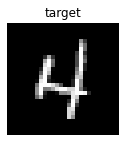

  0%|          | 0/5 [00:00<?, ?it/s]

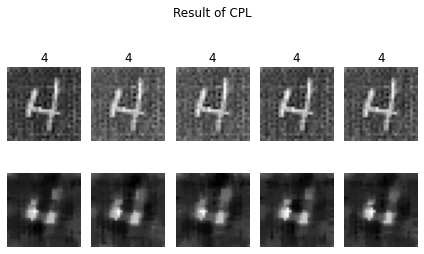

In [8]:
plt.figure(figsize=(2, 4))
plt.imshow(x[:1].detach().numpy()[0][0], cmap="gray")
plt.axis("off")
plt.title("target")
plt.show()

criterion = nn.CrossEntropyLoss()
net = LeNet(channel=channel, hideen=hidden, num_classes=num_classes)
pred = net(x[:1])
loss = criterion(pred, y[:1])
received_gradients = torch.autograd.grad(loss, net.parameters())
received_gradients = [cg.detach() for cg in received_gradients]

cpl_attacker = GradientInversion_Attack(net, (1, 28, 28), lr=10e2, log_interval=0,
                                    optimizer_class=torch.optim.SGD,
                                    distancename="l2", optimize_label=False,
                                    num_iteration=1000,
                                    lm_reg_coef=0.01)

num_seeds=5
fig = plt.figure()
for s in tqdm(range(num_seeds)):
    idlg_attacker.reset_seed(s)
    result = cpl_attacker.attack(received_gradients)
    ax1 = fig.add_subplot(2, num_seeds, s+1)
    ax1.imshow(result[0].detach().numpy()[0][0], cmap="gray")
    ax1.axis("off")
    ax1.set_title(result[1].item())
    ax2 = fig.add_subplot(2, num_seeds, num_seeds+s+1)
    ax2.imshow(cv2.medianBlur(result[0].detach().numpy()[0][0], 5), cmap="gray")
    ax2.axis("off")
plt.suptitle("Result of CPL")
plt.tight_layout()
plt.show()

## GradInversion
https://arxiv.org/abs/2104.07586
- distance metric = L2 norm
- optimize only images & estimate labels from the gradients
- total-variance, l2, bn, and group-consistency regularization

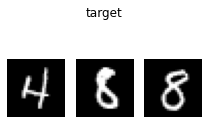

Text(0.5, 0.98, 'Result of GradInversion')

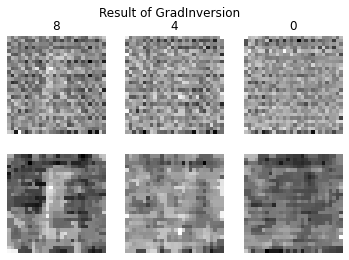

In [6]:
batch_size = 3

fig = plt.figure(figsize=(3, 2))
for bi in range(batch_size):
    ax = fig.add_subplot(1, batch_size, bi+1)
    ax.imshow(x[bi].detach().numpy()[0], cmap="gray")
    ax.axis("off")
plt.suptitle("target")
plt.tight_layout()
plt.show()

criterion = nn.CrossEntropyLoss()
net = LeNet(channel=channel, hideen=hidden, num_classes=num_classes)
pred = net(x[:batch_size])
loss = criterion(pred, y[:batch_size])
received_gradients = torch.autograd.grad(loss, net.parameters())
received_gradients = [cg.detach() for cg in received_gradients]

gradinversion = GradientInversion_Attack(net, (1, 28, 28), num_iteration=10000,
                                    lr=1e2, log_interval=0,
                                    optimizer_class=torch.optim.SGD,
                                    distancename="l2", optimize_label=False,
                                    bn_reg_layers=[net.body[1], net.body[4], net.body[7]],
                                    group_num = 5,
                                    tv_reg_coef=0.00, l2_reg_coef=0.0001,
                                    bn_reg_coef=0.001, gc_reg_coef=0.001)

result = gradinversion.group_attack(received_gradients, batch_size=batch_size)

fig = plt.figure()
for bid in range(batch_size):
    ax1 = fig.add_subplot(2, batch_size, bid+1)
    ax1.imshow((sum(result[0]) / len(result[0])).detach().numpy()[bid][0], cmap="gray")
    ax1.axis("off")
    ax1.set_title(result[1][0][bid].item())
    ax2 = fig.add_subplot(2, batch_size, batch_size+bid+1)
    ax2.imshow(cv2.medianBlur((sum(result[0]) / len(result[0])).detach().numpy()[bid][0], 3), cmap="gray")
    ax2.axis("off")

plt.suptitle("Result of GradInversion")